## 2.2 - Feature Selection 

Descargar el csv de https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min?resource=download 

In [ ]:
#Librerias

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import f_classif, RFE, SelectFromModel, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [6]:
dataset = pd.read_csv("high_diamond_ranked_10min.csv")
dataset.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [7]:
# Separar características (x) y variable objetivo (y) 
X = dataset.drop(columns=["blueWins"])
y = dataset["blueWins"]

# Entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [8]:
# Eliminación recursiva de características (RFE)
svc = SVC(kernel="linear")
rfe = RFE(estimator=svc, n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)


In [12]:
# Regresión Lasso
logistic = LogisticRegression(penalty="l1", solver="liblinear")
logistic.fit(X_train, y_train)
model = SelectFromModel(logistic, prefit=True)
X_train_l1 = model.transform(X_train)
X_test_l1 = model.transform(X_test)


In [13]:
# Selección Univariada
select_k_best = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = select_k_best.fit_transform(X_train, y_train)
X_test_kbest = select_k_best.transform(X_test)

In [17]:
# Entrenar y evaluar el modelo con cada selección
def train_evaluate_svm(X_train, X_test, y_train, y_test):
    svm = SVC(kernel="linear")
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return accuracy, precision, recall

# Evaluar modelo sin selección
accuracy_original, precision_original, recall_original = train_evaluate_svm(X_train, X_test, y_train, y_test)

# Evaluar modelo con RFE
accuracy_rfe, precision_rfe, recall_rfe = train_evaluate_svm(X_train_rfe, X_test_rfe, y_train, y_test)

# Evaluar modelo con Lasso
accuracy_l1, precision_l1, recall_l1 = train_evaluate_svm(X_train_l1, X_test_l1, y_train, y_test)

# Evaluar modelo con Selección Univariada
accuracy_kbest, precision_kbest, recall_kbest = train_evaluate_svm(X_train_kbest, X_test_kbest, y_train, y_test)

# Comparar resultados
results = pd.DataFrame({
    "Método": ["Sin Selección", "RFE", "Lasso", "Univariada"],
    "Accuracy": [accuracy_original, accuracy_rfe, accuracy_l1, accuracy_kbest],
    "Precision": [precision_original, precision_rfe, precision_l1, precision_kbest],
    "Recall": [recall_original, recall_rfe, recall_l1, recall_kbest]
})

print(results)



          Método  Accuracy  Precision    Recall
0  Sin Selección  0.730769   0.735444  0.725076
1            RFE  0.734312   0.733533  0.740181
2          Lasso  0.730769   0.735444  0.725076
3     Univariada  0.725202   0.728195  0.723061


### Justificación

Al igual que en el laboratorio anterior se utilizaron las métricas de desempeño de accuracy, precisión y recall. Esto debido a que en conjunto estas métricas ofrecen una vista completa del los resultados pues los últimos dos refuerzan los resultados del accuracy y garantizan un modelo seguro y con la menor cantidad de falsos positivos.

### Análisis de resultados

Los resultados estuvieron muy cercanos, sin embargo, el de RFE demostró tener un mayor desempeño. Esto debido a que tiene un accuracy y recall mayor y su presición no tiene diferencia significativa con los otros. 

## 2.3 - Perceptrón

In [36]:
# Librerias

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [37]:
# Cargar el dataset de Iris solo usando sepal lenght y sepal width

iris = load_iris()
X = iris.data[:, :2]
y = iris.target

X = X[y != 2]
y = y[y != 2]

y = np.where(y==0,-1,1)

# Entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [38]:
# Perceptrón
class Perceptron:
    def __init__(self, learning_rate, epochs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        for _ in range(self.epochs):
            for i in range(X.shape[0]):
                # Predicción
                y_pred = np.dot(X[i], self.weights) + self.bias
                y_pred = np.sign(y_pred)

                if y_pred != y[i]:
                    self.weights += self.learning_rate * y[i] * X[i]
                    self.bias += self.learning_rate *y[i]

    def predict(self, X):
        return np.sign(np.dot(X, self.weights) + self.bias)


In [39]:
# Iniciar y entrenar
perceptron = Perceptron(learning_rate=0.01, epochs=1000)
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)


In [40]:
# Evaluar
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Accuracy del modelo: {accuracy:.4f}")
print(f"Precisión del modelo: {precision:.4f}")
print(f"Recall del modelo: {recall:.4f}")

Accuracy del modelo: 1.0000
Precisión del modelo: 1.0000
Recall del modelo: 1.0000


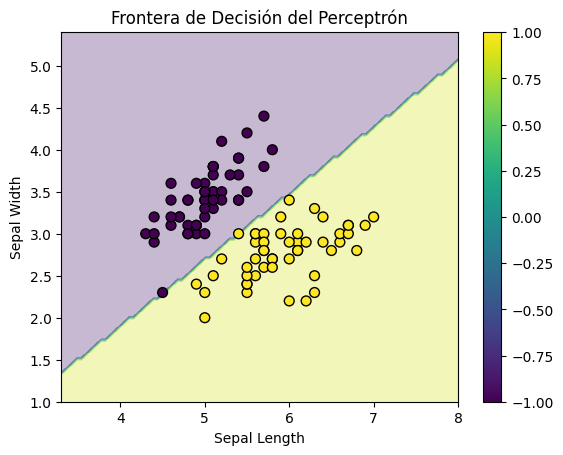

In [41]:
# Visualizar la frontera de decisión
xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
                     np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))

Z = perceptron.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50)
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('Frontera de Decisión del Perceptrón')
plt.colorbar()
plt.show()


### Justificación y resultados

Al igual que en el punto anterior, se utilizaron accuracy, precisión y recall por la visión completa de los resultados del modelo que ofrecen. Esto debido a que accuracy ofrece una medida completa pero penalizada por el desbalance de datos. Y precisión y recall ayudan a ver si los positivos son reales y correctos y no están penalizados por el desbalance por lo que ayudan a reforzar el accuracy.

Los resultados de las tres métricas fueron de 1. Esto es coherente con lo visto en la gráfica, ya que vemos que aunque algunos puntos se acercan a la frontera entre datos, realmente todos se mantienen dentro de sus zonas, por lo que se puede decir que el modelo puede clasificar los datos con mucha exactitud.


# Link github
https://github.com/Czar272/Lab3_AI